In [1]:
import tensorflow as tf
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint

Using TensorFlow backend.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

In [3]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from os import listdir

In [4]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

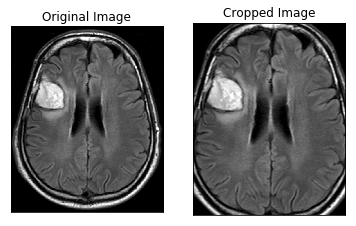

In [5]:
ex_img = cv2.imread('/home/gaurav/yes/Y7.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [6]:
def load_data(path_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for path in path_list:
        os.chdir(path)
        current_directory=os.getcwd()
        for filename in os.listdir(path):
            file_path=os.path.abspath(filename)
            print(file_path)
            # load the image
            image = cv2.imread(file_path)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if current_directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    X, y = shuffle(X, y)
    
    
    return X, y

    

In [7]:
yes_path = '/home/gaurav/yes'
no_path = '/home/gaurav/no'
#path_list=[yes_path,no_path]
IMG_WIDTH, IMG_HEIGHT = (240, 240)


X, y = load_data([yes_path, no_path], (IMG_WIDTH, IMG_HEIGHT))

/home/gaurav/yes/Y100.JPG
/home/gaurav/yes/Y10.jpg
/home/gaurav/yes/Y114.JPG
/home/gaurav/yes/Y14.jpg
/home/gaurav/yes/Y115.JPG
/home/gaurav/yes/Y108.jpg
/home/gaurav/yes/Y7.jpg
/home/gaurav/yes/Y111.JPG
/home/gaurav/yes/Y101.jpg
/home/gaurav/yes/Y1.jpg
/home/gaurav/yes/Y112.JPG
/home/gaurav/yes/Y116.JPG
/home/gaurav/yes/Y113.JPG
/home/gaurav/no/1 no.jpeg
/home/gaurav/no/6 no.jpg
/home/gaurav/no/no 5.jpeg
/home/gaurav/no/2 no.jpeg
/home/gaurav/no/No12.jpg
/home/gaurav/no/15 no.jpg
/home/gaurav/no/14 no.jpg
/home/gaurav/no/11 no.jpg
/home/gaurav/no/No13.jpg
/home/gaurav/no/no 6.jpg
/home/gaurav/no/No16.jpg
/home/gaurav/no/no 4.jpg
/home/gaurav/no/12 no.jpg
/home/gaurav/no/No14.jpg
/home/gaurav/no/13 no.jpg
/home/gaurav/no/no 2.jpg
/home/gaurav/no/No11.jpg
/home/gaurav/no/no 3.jpg
/home/gaurav/no/No17.jpg
/home/gaurav/no/7 no.jpg
/home/gaurav/no/35 no.jpg
/home/gaurav/no/10 no.jpg
/home/gaurav/no/No15.jpg


In [8]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle("Brain Tumor: " + label_to_str(label))
        plt.show()

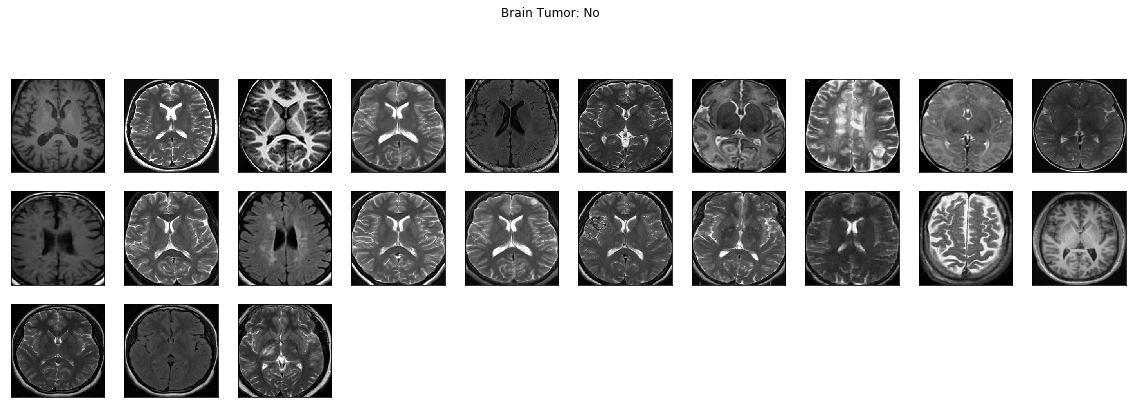

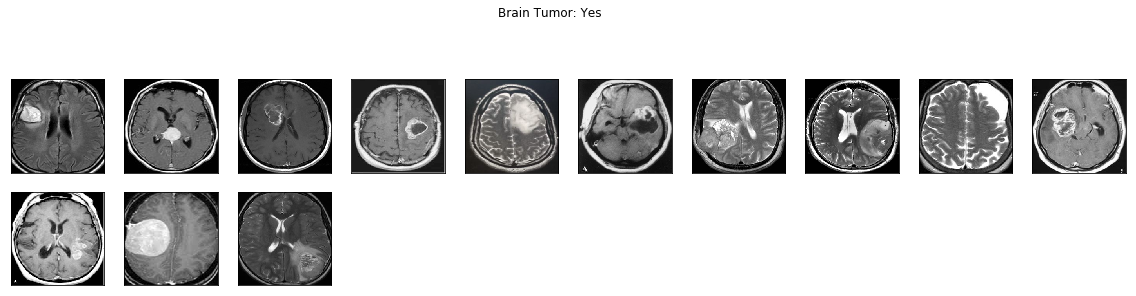

In [9]:
plot_sample_images(X, y)

In [10]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)


In [12]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 25
number of development examples = 6
number of test examples = 5
X_train shape: (25, 240, 240, 3)
Y_train shape: (25, 1)
X_val (dev) shape: (6, 240, 240, 3)
Y_val (dev) shape: (6, 1)
X_test shape: (5, 240, 240, 3)
Y_test shape: (5, 1)


In [13]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{h}:{m}:{round(s,1)}"

In [14]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [15]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [16]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)


In [17]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 240, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)        0         
__________

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [19]:
# tensorboard
log_file_name = 'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir='logs/{log_file_name}')


In [24]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("/home/gaurav/models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

In [25]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print("Elapsed time: {hms_string(execution_time)}")

Train on 25 samples, validate on 6 samples
Epoch 1/10
25/25 [==============================] - 11s 420ms/step - loss: 1.8692 - acc: 0.6800 - val_loss: 0.8155 - val_acc: 0.6667
Epoch 2/10
25/25 [==============================] - 9s 373ms/step - loss: 0.5476 - acc: 0.7200 - val_loss: 0.8102 - val_acc: 0.6667
Epoch 3/10
25/25 [==============================] - 9s 370ms/step - loss: 0.7231 - acc: 0.6000 - val_loss: 1.1000 - val_acc: 0.6667
Epoch 4/10
25/25 [==============================] - 10s 381ms/step - loss: 1.0637 - acc: 0.4000 - val_loss: 0.6733 - val_acc: 0.6667
Epoch 5/10
25/25 [==============================] - 9s 378ms/step - loss: 0.5615 - acc: 0.7600 - val_loss: 0.3311 - val_acc: 0.8333
Epoch 6/10
25/25 [==============================] - 9s 380ms/step - loss: 0.2209 - acc: 0.9200 - val_loss: 0.8382 - val_acc: 0.5000
Epoch 7/10
25/25 [==============================] - 11s 451ms/step - loss: 0.2927 - acc: 0.8800 - val_loss: 1.5977 - val_acc: 0.3333
Epoch 8/10
25/25 [============

In [29]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print("Elapsed time:" + str(hms_string(execution_time)))

Train on 25 samples, validate on 6 samples
Epoch 1/3
25/25 [==============================] - 10s 411ms/step - loss: 0.1782 - acc: 0.9200 - val_loss: 0.9516 - val_acc: 0.6667
Epoch 2/3
25/25 [==============================] - 9s 368ms/step - loss: 0.2045 - acc: 0.9200 - val_loss: 0.8777 - val_acc: 0.6667
Epoch 3/3
25/25 [==============================] - 9s 369ms/step - loss: 0.1671 - acc: 0.9200 - val_loss: 0.7137 - val_acc: 0.8333
Elapsed time:{h}:{m}:{round(s,1)}


In [30]:
history = model.history.history
for key in history.keys():
    print(key)

acc
loss
val_acc
val_loss


In [31]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

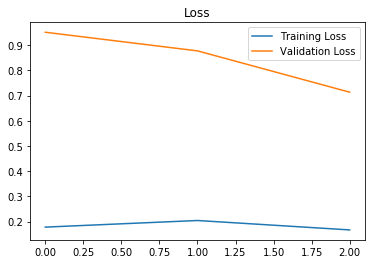

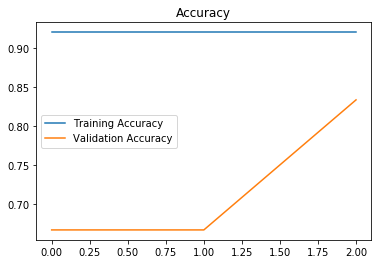

In [32]:
plot_metrics(history)


In [34]:
best_model = load_model(filepath='/home/gaurav/models/cnn-parameters-improvement-10-0.83.model')


In [35]:
best_model.metrics_names


['loss', 'acc']

In [36]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)


5/5 [==============================] - 1s 238ms/step


In [38]:
print ("Test Loss = %s" %loss)
print ("Test Accuracy = %s" %acc)

Test Loss = 0.19265756011009216
Test Accuracy = 0.800000011920929
